In [1]:
MAPILLARY_TO_CITYSCAPES = {
    7: 'road',
    8: 'sidewalk',
    11: 'building',
    12: 'wall',
    13: 'fence',
    17: 'pole',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
    
    # Neue Klasse für Fahrbahnmarkierungen (Lane Markings)
    200: 'lane marking',

    # Alle nicht benötigten Klassen werden als 'unlabeled' behandelt
    0: 'unlabeled'
}

In [2]:
import json
with open("Mapilarry_Vistas/config_v2.0.json", "r") as f:
    config = json.load(f)

for i, info in enumerate(config["labels"]):
    print(i, info["readable"], info["color"])

# Erstelle die Colormap als Dictionary
colormap = {i: info["color"] for i, info in enumerate(config["labels"])}

# Speichere die Colormap als JSON
with open("Colormap/mapillary_colormap.json", "w") as f:
    json.dump(colormap, f, indent= 1)


0 Bird [165, 42, 42]
1 Ground Animal [0, 192, 0]
2 Ambiguous Barrier [250, 170, 31]
3 Concrete Block [250, 170, 32]
4 Curb [196, 196, 196]
5 Fence [190, 153, 153]
6 Guard Rail [180, 165, 180]
7 Barrier [90, 120, 150]
8 Road Median [250, 170, 33]
9 Road Side [250, 170, 34]
10 Lane Separator [128, 128, 128]
11 Temporary Barrier [250, 170, 35]
12 Wall [102, 102, 156]
13 Bike Lane [128, 64, 255]
14 Crosswalk - Plain [140, 140, 200]
15 Curb Cut [170, 170, 170]
16 Driveway [250, 170, 36]
17 Parking [250, 170, 160]
18 Parking Aisle [250, 170, 37]
19 Pedestrian Area [96, 96, 96]
20 Rail Track [230, 150, 140]
21 Road [128, 64, 128]
22 Road Shoulder [110, 110, 110]
23 Service Lane [110, 110, 110]
24 Sidewalk [244, 35, 232]
25 Traffic Island [128, 196, 128]
26 Bridge [150, 100, 100]
27 Building [70, 70, 70]
28 Garage [150, 150, 150]
29 Tunnel [150, 120, 90]
30 Person [220, 20, 60]
31 Person Group [220, 20, 60]
32 Bicyclist [255, 0, 0]
33 Motorcyclist [255, 0, 100]
34 Other Rider [255, 0, 200]
35 

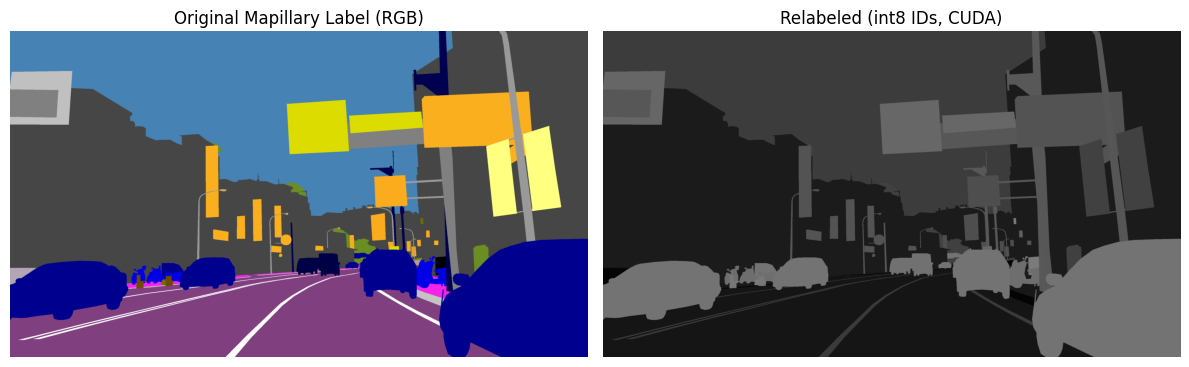

In [3]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

def mapillary_to_int8_cuda(
    config_path="Mapilarry_Vistas/config_v2.0.json",
    label_path="Mapilarry_Vistas/validation/v2.0/labels/_G--4T8xsKtSDNBXVPDrxg.png"
):
    """
    Nutzt die GPU (CUDA) für schnelles Mapping von Mapillary-Labels zu int8.
    """

    # Prüfen, ob CUDA verfügbar ist
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA ist nicht verfügbar. Stelle sicher, dass du eine kompatible GPU verwendest.")

    # Mapillary-Konfiguration laden
    with open(config_path, "r") as f:
        config = json.load(f)
    labels = config["labels"]

    # Farbe -> Mapillary-ID
    color_to_mID = {tuple(label["color"]): idx for idx, label in enumerate(labels)}

    # Labelbild laden
    orig_img = Image.open(label_path).convert("RGB")
    np_img = np.array(orig_img)
    h, w, _ = np_img.shape

    # Bild auf GPU übertragen
    img_tensor = torch.tensor(np_img, device="cuda", dtype=torch.uint8)

    # Unique Farben auf GPU berechnen
    unique_colors = img_tensor.view(-1, 3).unique(dim=0)

    # Ausgabe-Array auf GPU vorbereiten
    result_tensor = torch.zeros((h, w), device="cuda", dtype=torch.uint8)

    # Mapping durchführen
    for color in unique_colors:
        color_tuple = tuple(color.tolist())
        mID = color_to_mID.get(color_tuple, -1)
        int8_ID = mID if mID >= 0 else 255

        # Maske erstellen und Werte setzen
        mask = (img_tensor[:, :, 0] == color[0]) & \
               (img_tensor[:, :, 1] == color[1]) & \
               (img_tensor[:, :, 2] == color[2])
        result_tensor[mask] = int8_ID

    # Ergebnis zurück auf die CPU holen
    result_array = result_tensor.cpu().numpy()

    # Visualisieren
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
    ax[0].imshow(np_img)
    ax[0].set_title("Original Mapillary Label (RGB)")
    ax[0].axis("off")

    ax[1].imshow(result_array, cmap="gray", vmin=0, vmax=255)
    ax[1].set_title("Relabeled (int8 IDs, CUDA)")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Wenn du das Skript direkt ausführen willst, entkommentiere:
mapillary_to_int8_cuda()


In [4]:
import os
import json
import numpy as np
import torch
import tqdm
from PIL import Image

def mapillary_to_int8_cuda_batch(
    config_path="Mapilarry_Vistas/config_v2.0.json",
    origin_folder="Mapilarry_Vistas/training/v2.0/labels",
    destination_folder="Mapilarry_Vistas/training_own_2"
):
    """
    Nutzt die GPU (CUDA) für schnelles Mapping von Mapillary-Labels zu int8
    für alle Bilder in einem Ordner.
    """
    # Prüfen, ob CUDA verfügbar ist
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA ist nicht verfügbar. Stelle sicher, dass du eine kompatible GPU verwendest.")

    # Mapillary-Konfiguration laden
    with open(config_path, "r") as f:
        config = json.load(f)
    labels = config["labels"]

    # Farbe -> Mapillary-ID
    color_to_mID = {tuple(label["color"]): idx for idx, label in enumerate(labels)}

    # Zielordner erstellen, falls nicht vorhanden
    os.makedirs(destination_folder, exist_ok=True)

    # Liste der Dateien im Origin-Ordner
    file_list = [f for f in os.listdir(origin_folder) if f.endswith(".png")]

    # Fortschrittsanzeige
    for file_name in tqdm.tqdm(file_list, desc="Processing images", unit="file"):
        # Voller Pfad der Eingabedatei
        input_path = os.path.join(origin_folder, file_name)

        # Labelbild laden
        orig_img = Image.open(input_path).convert("RGB")
        np_img = np.array(orig_img)
        h, w, _ = np_img.shape

        # Bild auf GPU übertragen
        img_tensor = torch.tensor(np_img, device="cuda", dtype=torch.uint8)

        # Unique Farben auf GPU berechnen
        unique_colors = img_tensor.view(-1, 3).unique(dim=0)

        # Ausgabe-Array auf GPU vorbereiten
        result_tensor = torch.zeros((h, w), device="cuda", dtype=torch.uint8)

        # Mapping durchführen
        for color in unique_colors:
            color_tuple = tuple(color.tolist())
            mID = color_to_mID.get(color_tuple, -1)
            int8_ID = mID if mID >= 0 else 255

            # Maske erstellen und Werte setzen
            mask = (img_tensor[:, :, 0] == color[0]) & \
                   (img_tensor[:, :, 1] == color[1]) & \
                   (img_tensor[:, :, 2] == color[2])
            result_tensor[mask] = int8_ID

        # Ergebnis zurück auf die CPU holen
        result_array = result_tensor.cpu().numpy()

        # Relabeled Bild speichern
        output_path = os.path.join(destination_folder, file_name)
        Image.fromarray(result_array).save(output_path)

    print(f"Alle Bilder wurden erfolgreich verarbeitet und gespeichert unter: {destination_folder}")

# Wenn du das Skript direkt ausführen willst, entkommentiere:
mapillary_to_int8_cuda_batch()


Processing images:   2%|▏         | 311/18001 [00:40<38:45,  7.61file/s] 


KeyboardInterrupt: 